In [35]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import join, isfile

# info tables
sim_info = f'/data01/homes/dipiano/E4/irf_random/crab/map_100s_200x200/merged_simulator_data.dat'
map_info = f'/data01/homes/dipiano/E4/irf_random/crab/map_100s_200x200/merged_mapper_data.dat'

# dataset 
filename = '/data01/homes/dipiano/E4/irf_random/crab/cleaner_100s_5sgm_5000sz_200x200_YESnorm_NOstretch.npy'
ds = np.load(filename, allow_pickle=True, encoding='latin1', fix_imports=True).flat[0]
print(f"Classes: {ds.keys()}\n")
print(f"NOISY dataset size: {len(ds['DS1'])}")
print(f"CLEAN dataset size: {len(ds['DS2'])}")

print(ds['DS1'][0].shape)

Classes: dict_keys(['DS1', 'DS2'])

NOISY dataset size: 5000
CLEAN dataset size: 5000
(200, 200)


In [36]:
from astroai.tools.utils import split_noisy_dataset

train_noisy, train_clean, test_noisy, test_clean = split_noisy_dataset(ds, split=80, reshape=True, binning=200)

print(f"Train clean: {train_clean.shape}")
print(f"Train noisy: {train_noisy.shape}")
print(f"\nTest clean: {test_clean.shape}")
print(f"Test labenoicyls: {test_noisy.shape}")

Train clean: (4000, 200, 200, 1)
Train noisy: (4000, 200, 200, 1)

Test clean: (1000, 200, 200, 1)
Test labenoicyls: (1000, 200, 200, 1)


In [37]:
infodata = pd.read_csv(sim_info, sep=' ', header=0).sort_values(by=['seed'])
infodata.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
15000,crab_00001,1,0,100,100,57.265654,30.447065,57.253328,30.454269,0.012838,North_z40_S_0.5h_LST,2.5,7.322825
15001,crab_00002,2,0,100,100,98.177801,40.950640,98.016897,41.081760,0.178695,North_z60_N_50h_LST,2.5,6.762409
15002,crab_00003,3,0,100,100,76.984211,-66.348920,78.358890,-67.138246,0.957894,North_z40_N_5h_LST,2.5,7.029939
15003,crab_00004,4,0,100,100,125.495725,-44.424075,126.479118,-43.608941,1.079135,North_z40_5h_LST,2.5,7.074566
15004,crab_00005,5,0,100,100,214.162576,42.736282,215.790559,43.357500,1.342109,North_z20_5h_LST,2.5,7.087336


In [38]:
from astroai.tools.utils import plot_heatmap

idx = np.random.choice(range(len(test_noisy)))
# find seed to get the original heatmap
seed = len(train_noisy) + idx + 1
print(seed)

row = infodata[infodata['seed']==seed]
row

4567


,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
19566,crab_04567,4567,0,100,100,11.612845,70.394336,11.345408,70.488819,0.130164,North_z40_5h_LST,2.5,6.920257


## Load model and weights

In [39]:
import tensorflow as tf

savename = 'cleaner_200x200_filter2_70p' 
model = tf.keras.models.load_model(f'../models/{savename}.keras')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 2)       10        
                                                                 
 average_pooling2d (AverageP  (None, 100, 100, 2)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 2)       18        
                                                                 
 average_pooling2d_1 (Averag  (None, 50, 50, 2)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 2)         18    

In [40]:
%time
predictions = model.predict(test_noisy)

CPU times: user 9 µs, sys: 3 µs, total: 12 µs
Wall time: 23.8 µs
32/32 [==============================] - 1s 32ms/step


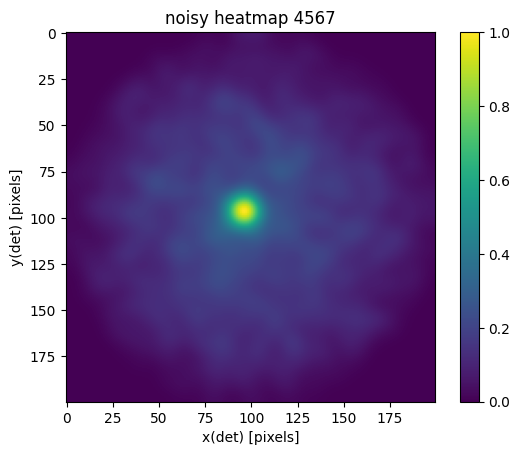

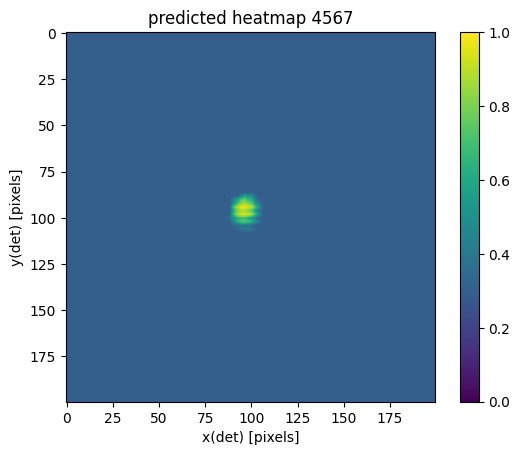

In [41]:
# plot noisy and prediction
plot_heatmap(test_noisy[idx], title=f'noisy heatmap {seed}', show=True, save=False, save_name=None)
plot_heatmap(predictions[idx], title=f'predicted heatmap {seed}', show=True, save=False, save_name=None)

# Revert normalisation

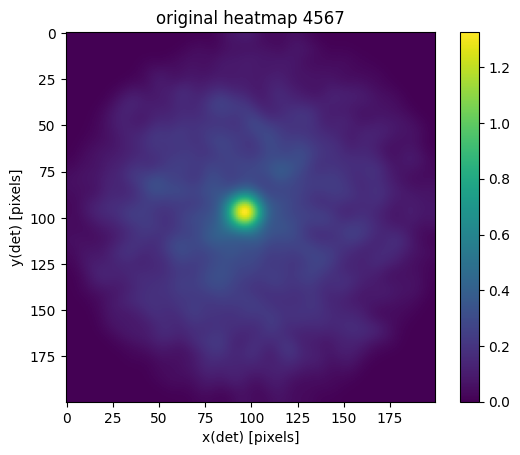

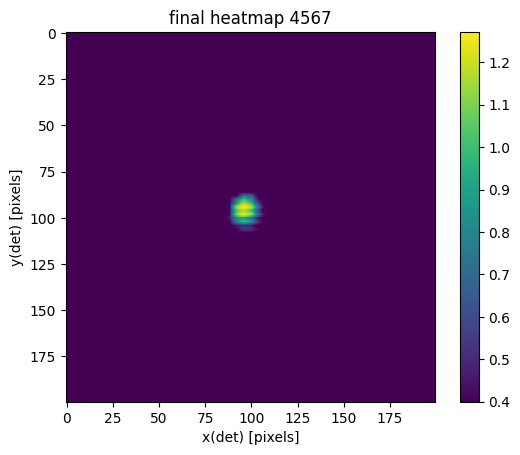

(1.2708753, 1.3261463580696466)

In [42]:
import numpy as np
from astropy.table import Table
from astroai.tools.utils import revert_normalise_heatmap
from astroai.tools.utils import extract_heatmap_from_table, normalise_heatmap

original = f'/data01/homes/dipiano/E4/irf_random/crab/sim/crab_{seed:05d}.fits'
original_heatmap = Table.read(original, hdu=1).to_pandas()
original_heatmap = extract_heatmap_from_table(original_heatmap, trange=[0, 100], smoothing=5, nbins=200)
plot_heatmap(np.rot90(original_heatmap), title=f'original heatmap {seed}', show=True, vnorm=False)

revert_norm_heatmap = revert_normalise_heatmap(predictions[idx], original_heatmap)
plot_heatmap(revert_norm_heatmap, title=f'final heatmap {seed}', show=True, vnorm=False)

np.max(revert_norm_heatmap), np.max(original_heatmap)

# Localise source

In [43]:
savename = 'regressor_200x200_filter2_90kp_sigmoid' 
model = tf.keras.models.load_model(f'../models/{savename}.keras')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 197, 197, 2)       34        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 98, 98, 2)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 4)         36        
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 4)         68        
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 95, 4)         68        
                                                                 
 conv2d_4 (Conv2D)           (None, 94, 94, 4)         68        
                                                        

In [44]:
binning = 200 

# before cleaning
regressions_noisy = model.predict(test_noisy) * binning

# after cleaning
regressions = model.predict(predictions) * binning

32/32 [==============================] - 1s 16ms/step


In [45]:
from astroai.tools.utils import *
from astropy.coordinates import SkyCoord

w = set_wcs(point_ra=row['point_ra'].values[0], point_dec=row['point_dec'].values[0], 
            point_ref=binning/2, pixelsize=2*row['fov'].values[0]/binning)

# get coordinates before cleaning
x_noisy, y_noisy = regressions_noisy[idx][0], regressions_noisy[idx][1]
sky_noisy = w.pixel_to_world(x_noisy, y_noisy)

# get coordinate after cleaning
x, y = regressions[idx][0], regressions[idx][1]
sky = w.pixel_to_world(x, y)

# get true coordinates in SkyCoord
true = SkyCoord(ra=row['source_ra'].values[0], dec=row['source_dec'].values[0], unit='deg', frame='icrs')

# get errors
err_noisy = true.separation(sky_noisy)
err = true.separation(sky)

print(f"TRUE: ({true.ra.deg}, {true.dec.deg})\n")

print(f"NOISY PREDICTION: ({sky_noisy.ra.deg}, {sky_noisy.dec.deg})")
print(f"CLEAN PREDICTION: ({sky.ra.deg}, {sky.dec.deg})\n")

print(f"NOISY ERR: {err_noisy.deg}")
print(f"CLEAN ERR: {err.deg}")

TRUE: (11.612845337212365, 70.39433561897523)

NOISY PREDICTION: (11.21011581977973, 70.43032314077479)
CLEAN PREDICTION: (11.218958748954151, 70.41453415736589)

NOISY ERR: 0.13972817800997045
CLEAN ERR: 0.1336361850203584


# plot map and prediction  
plot_heatmap(np.rot90(original_heatmap), title=f'original heatmap {seed}', show=True, add_markers={'SRC': [x, y]}, 
             vnorm=False)
plot_heatmap(revert_norm_heatmap, title=f'cleaned heatmap {seed}', show=True, add_markers={'SRC': [x, y]}, 
             vnorm=False)